<a href="https://colab.research.google.com/github/Huypham07/Student-performance-prediction/blob/huy-branch/Student_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance Prediction

**Vấn đề**: Hệ thống cảnh báo sớm học sinh có nguy cơ trượt môn, dự đoán điểm của học sinh ở kỳ kiểm tra tiếp theo dựa trên kết quả học tập hiện tại, thói quen học tập, yếu tố cá nhân.

**Môn học:** Data Science  
**Thành viên nhóm:** ...  
**Dataset:** Student Performance Prediction  

---

## Mục tiêu:
1. Phân tích mô tả dữ liệu, tìm hiểu các yếu tố ảnh hưởng đến điểm số học sinh.
2. Phát hiện học sinh có nguy cơ trượt môn (Điểm < 40)
3. Dự đoán điểm của học sinh ở kỳ kiểm tra tiếp theo

---
## Outline các phần chính:
1. EDA & Xác định yếu tố ảnh hưởng
2. Phân loại học sinh
3. Dự đoán điểm số
4. Hồi quy: Dự đoán điểm Toán
5. Đánh giá mô hình


## 1. EDA & Xác định yếu tố ảnh hưởng
- Chuẩn bị thư viện, dataset
- Phân tích thống kê
- Xác định feature quan trọng nhất ảnh hưởng tới điểm

### Import thư viện, dataset

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datascience import *

from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [22]:
data = pd.read_csv('student_performance_dataset.csv')
data.head(5)

,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass


In [23]:
data.info()

col_names = data.columns
data_types = [data[col].dtype for col in col_names]
unique_values = [list(data[col].unique()) for col in col_names]
missing_values = [data[col].isnull().sum() for col in col_names]

table_col_info = Table().with_columns(
    "Col_name", col_names,
    "Data_type", data_types,
    "Unique_values", unique_values,
    "Missing_values", missing_values
)

display(table_col_info)

data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  708 non-null    object 
 1   Gender                      708 non-null    object 
 2   Study_Hours_per_Week        708 non-null    int64  
 3   Attendance_Rate             708 non-null    float64
 4   Past_Exam_Scores            708 non-null    int64  
 5   Parental_Education_Level    708 non-null    object 
 6   Internet_Access_at_Home     708 non-null    object 
 7   Extracurricular_Activities  708 non-null    object 
 8   Final_Exam_Score            708 non-null    int64  
 9   Pass_Fail                   708 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 55.4+ KB


Col_name,Data_type,Unique_values,Missing_values
Student_ID,object,"['S147', 'S136', 'S209', 'S458', 'S078', 'S417', 'S302', ...",0
Gender,object,"['Male', 'Female']",0
Study_Hours_per_Week,int64,"[31, 16, 21, 27, 37, 30, 24, 34, 35, 11, 25, 18, 12, 32, ...",0
Attendance_Rate,float64,"[68.267840983702882, 78.222927126132063, 87.525096238265 ...",0
Past_Exam_Scores,int64,"[86, 73, 74, 99, 63, 77, 95, 78, 94, 58, 81, 64, 62, 71, ...",0
Parental_Education_Level,object,"['High School', 'PhD', 'Bachelors', 'Masters']",0
Internet_Access_at_Home,object,"['Yes', 'No']",0
Extracurricular_Activities,object,"['Yes', 'No']",0
Final_Exam_Score,int64,"[63, 50, 55, 65, 70, 61, 57, 62, 59, 77, 56, 58, 64, 71, ...",0
Pass_Fail,object,"['Pass', 'Fail']",0


,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Final_Exam_Score
count,708.000000,708.000000,708.000000,708.000000
mean,26.132768,78.107722,77.871469,58.771186
std,8.877727,13.802802,14.402739,6.705877
min,10.000000,50.116970,50.000000,50.000000
25%,19.000000,67.550094,65.000000,52.000000
50%,27.000000,79.363046,79.000000,59.500000
75%,34.000000,89.504232,91.000000,64.000000
max,39.000000,99.967675,100.000000,77.000000


#### Tổng quan dữ liệu
Dataset này (708 hàng, 10 cột) chứa thông tin về kết quả học tập của học sinh, thói quen học tập và các yếu tố bên ngoài ảnh hưởng đến điểm thi cuối kỳ. Dataset được thiết kế nhằm phục vụ cho các bài toán dự báo, trực quan hóa dữ liệu và phân tích giáo dục.

#### Các thuộc tính:
- `Student_ID` : Mã số định danh duy nhất của mỗi học sinh.
- `Gender` : Giới tính của học sinh (Male/Female).
- `Study_Hours_per_Week` : Số giờ học trung bình mỗi tuần.
- `Attendance_Rate` : Tỷ lệ chuyên cần (% số buổi tham gia học, dao động từ 50% đến 100%).
- `Past_Exam_Scores` : Điểm trung bình các bài kiểm tra trước đó (thang điểm từ 50 đến 100).
- `Parental_Education_Level` : Trình độ học vấn của phụ huynh (High School, Bachelors, Masters, PhD).
- `Internet_Access_at_Home` : Học sinh có truy cập internet tại nhà hay không (Yes/No).
- `Extracurricular_Activities` : Học sinh có tham gia hoạt động ngoại khóa hay không (Yes/No).
- `Final_Exam_Score (Target)` : Điểm thi cuối kỳ của học sinh (thang điểm từ 50 đến 100).
- `Pass_Fail (Target)` : Kết quả học tập cuối kỳ của học sinh (Pass/Fail).

### Phân tích thống kê

In [24]:
data.columns

Index(['Student_ID', 'Gender', 'Study_Hours_per_Week', 'Attendance_Rate',
       'Past_Exam_Scores', 'Parental_Education_Level',
       'Internet_Access_at_Home', 'Extracurricular_Activities',
       'Final_Exam_Score', 'Pass_Fail'],
      dtype='object')

In [25]:
cols = ['Student_ID', 'Gender', 'Study_Hours_per_Week', 'Attendance_Rate',
       'Past_Exam_Scores', 'Parental_Education_Level',
       'Internet_Access_at_Home', 'Extracurricular_Activities',
       'Final_Exam_Score', 'Pass_Fail']

In [26]:
# Đảm bào tất cả đều là số
numeric_cols = ['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Final_Exam_Score']
for col in numeric_cols:
  data[col] = pd.to_numeric(data[col], errors='coerce')

# Bỏ đi cột Student_ID
data.drop(columns="Student_ID", inplace=True)

# Bỏ lặp
data.drop_duplicates(inplace=True)

# Chuyển các cột với category type
cat_cols = ['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities', 'Pass_Fail']
for col in cat_cols:
  data[col] = data[col].astype('category')

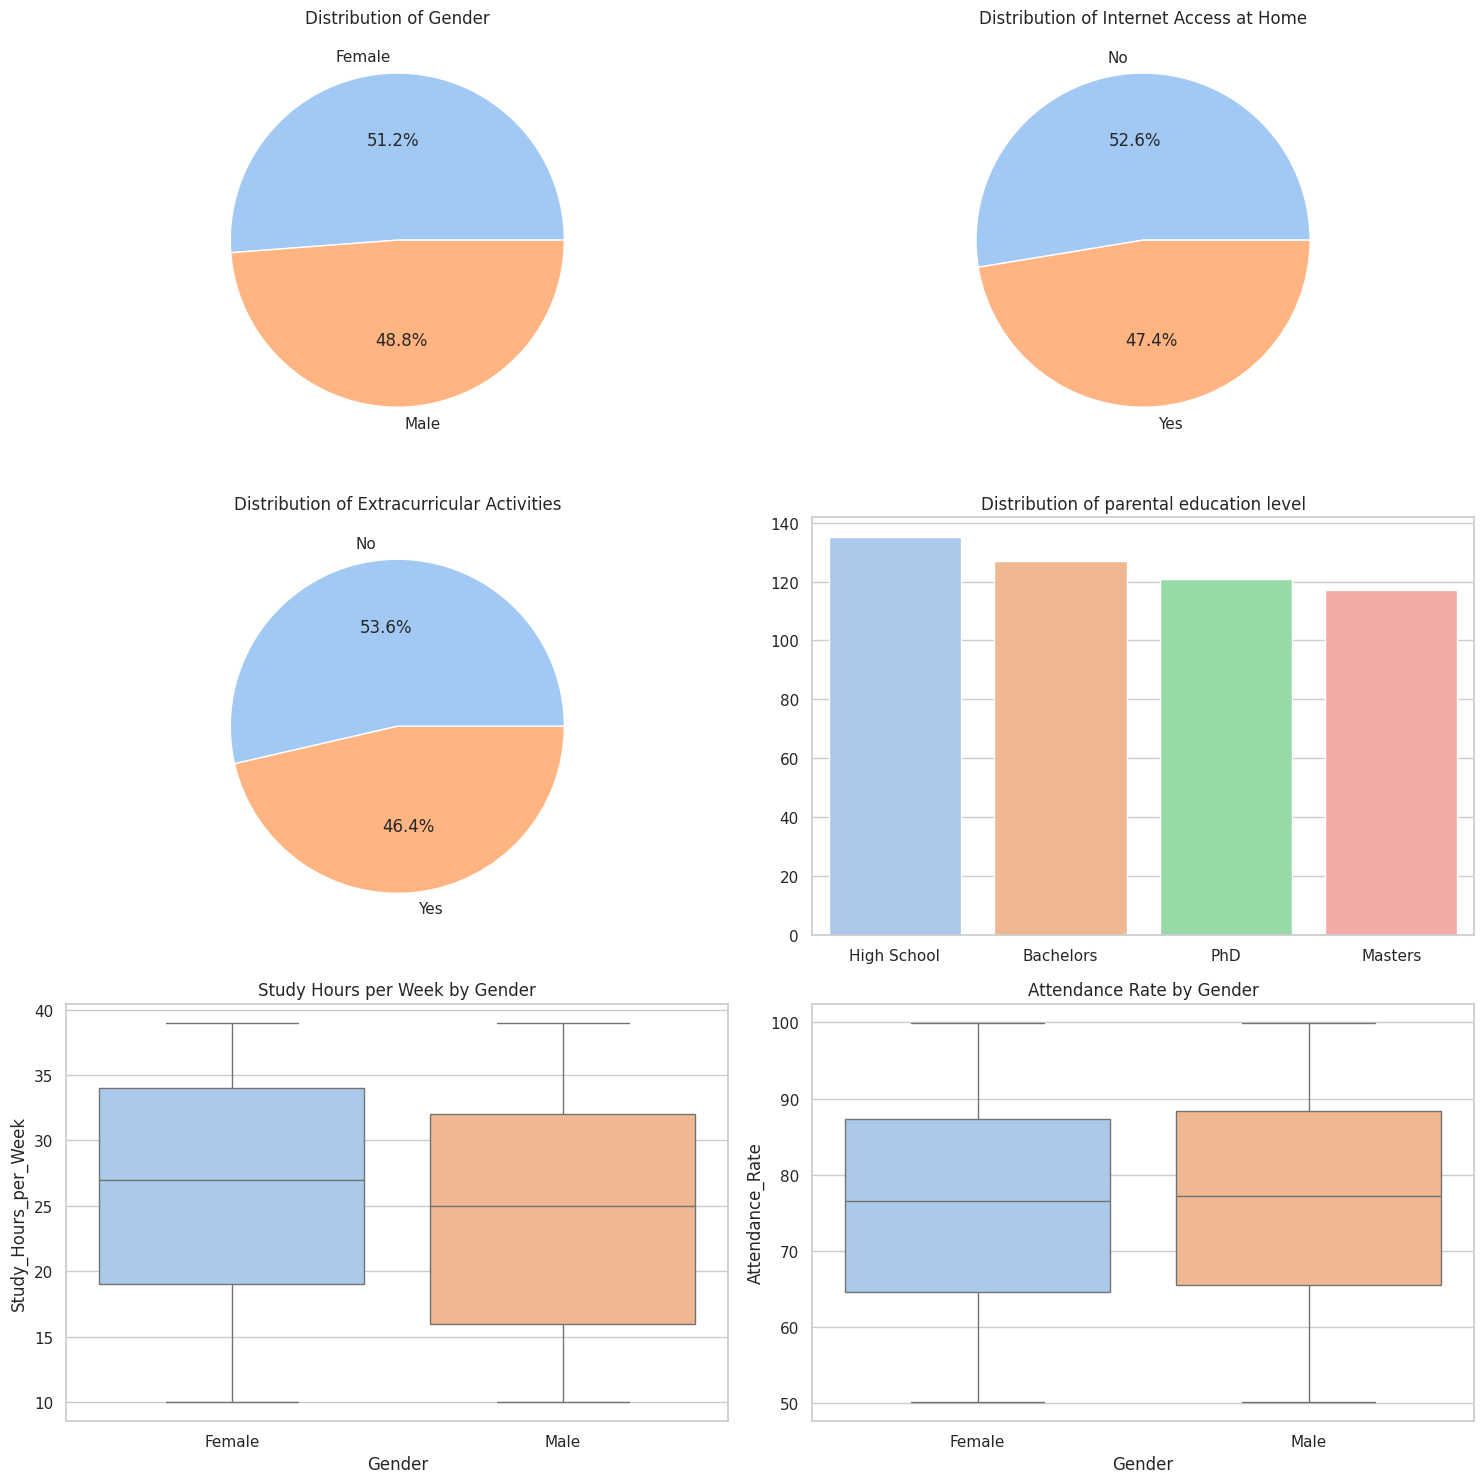

In [27]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Gender
genders = data['Gender'].value_counts().to_dict()
axes[0, 0].pie(genders.values(), labels=genders.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[0, 0].set_title('Distribution of Gender')

# Internet_Access_at_Home
itn_access = data['Internet_Access_at_Home'].value_counts().to_dict()
axes[0, 1].pie(itn_access.values(), labels=itn_access.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[0, 1].set_title('Distribution of Internet Access at Home')

# Extracurricular_Activities
extr_act = data['Extracurricular_Activities'].value_counts().to_dict()
axes[1, 0].pie(extr_act.values(), labels=extr_act.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[1, 0].set_title('Distribution of Extracurricular Activities')

# Parental_Education_Level
par_edu = data['Parental_Education_Level'].value_counts().to_dict()
sns.barplot(x=list(par_edu.keys()), y=list(par_edu.values()), ax=axes[1, 1], palette='pastel', hue=list(par_edu.keys()))
axes[1, 1].set_title('Distribution of parental education level')

# Study Hours per Week by Gender
sns.boxplot(x='Gender', y='Study_Hours_per_Week', data=data, palette='pastel', hue='Gender', ax=axes[2, 0])
axes[2, 0].set_title('Study Hours per Week by Gender')

# Attendance_Rate by Gender
sns.boxplot(x='Gender', y='Attendance_Rate', data=data, palette='pastel', hue='Gender', ax=axes[2, 1])
axes[2, 1].set_title('Attendance Rate by Gender')

plt.tight_layout()
plt.show()


In [28]:
# xác định xem bao nhiêu điểm thì là Pass:
pass_min_score = data[data['Pass_Fail'] == 'Pass']['Final_Exam_Score'].min()
print("Điểm thấp nhất để pass là:", pass_min_score)

fail_max_score = data[data['Pass_Fail'] == 'Fail']['Final_Exam_Score'].max()
print("Điểm cao nhất trong nhóm Fail là:", fail_max_score)

Điểm thấp nhất để pass là: 60
Điểm cao nhất trong nhóm Fail là: 59


$\Rightarrow$ Ngưỡng điểm để pass là 60

In [29]:
# độ tương quan giữa các cột số
data[numeric_cols].corr()

,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Final_Exam_Score
Study_Hours_per_Week,1.000000,-0.039701,-0.013381,0.374708
Attendance_Rate,-0.039701,1.000000,-0.022741,0.435714
Past_Exam_Scores,-0.013381,-0.022741,1.000000,0.474257
Final_Exam_Score,0.374708,0.435714,0.474257,1.000000


In [30]:
data[numeric_cols].corr()["Final_Exam_Score"]

,Final_Exam_Score
Study_Hours_per_Week,0.374708
Attendance_Rate,0.435714
Past_Exam_Scores,0.474257
Final_Exam_Score,1.000000


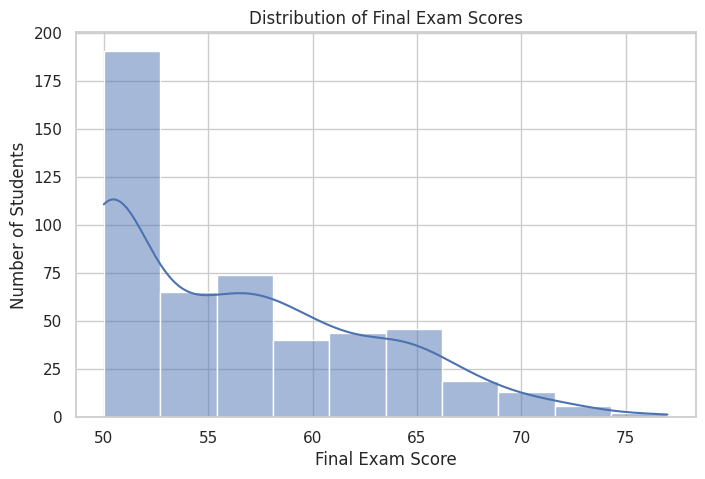

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Final_Exam_Score'], kde=True)

plt.title('Distribution of Final Exam Scores')
plt.xlabel('Final Exam Score')
plt.ylabel('Number of Students')
plt.show()

$\Rightarrow$ **Phân tích phân phối điểm thi cuối kỳ:**

Biểu đồ phân phối toàn bộ cột `Final_Exam_Score` cho thấy dữ liệu bị lệch trái rõ rệt. Phần lớn học sinh có điểm thi dao động quanh mức 50–55, với một số ít học sinh đạt điểm cao từ 65 trở lên.

Đặc biệt, có hiện tượng tập trung điểm tại mức thấp nhất (50 điểm), cho thấy tồn tại nhiều học sinh có nguy cơ trượt. Điều này là căn cứ quan trọng để xây dựng hệ thống cảnh báo học sinh yếu, cũng như mô hình dự đoán xác suất rớt môn.

Phân phối không tuân theo luật chuẩn, điều này sẽ được làm rõ hơn qua phần mô phỏng phân phối trung bình mẫu (CLT) và các bước Bootstrap


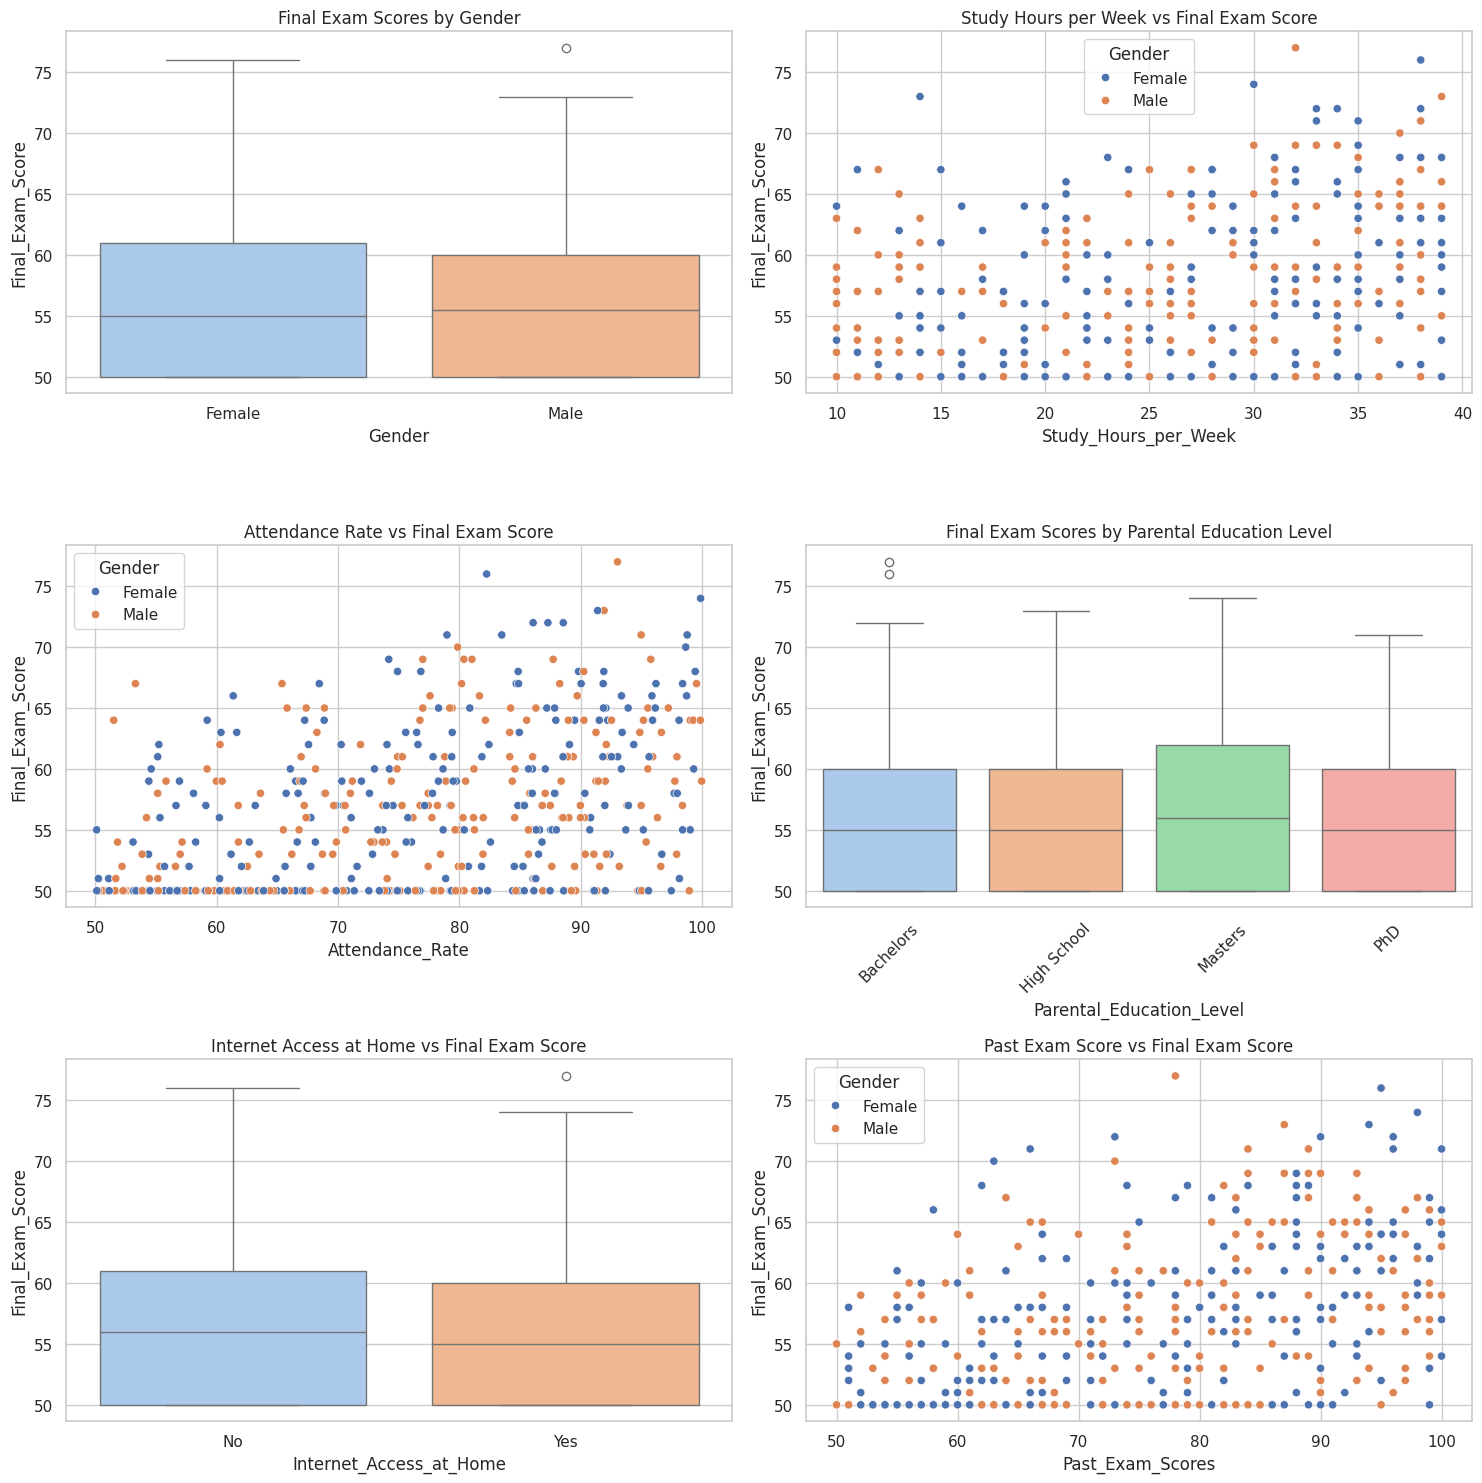

In [32]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Final Exam Scores by Gender
sns.boxplot(x='Gender', y='Final_Exam_Score', data=data, ax=axes[0, 0], palette='pastel', hue='Gender')
axes[0, 0].set_title('Final Exam Scores by Gender')

# Study Hours per Week vs Final Exam Score
sns.scatterplot(x='Study_Hours_per_Week', y='Final_Exam_Score', hue='Gender', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Study Hours per Week vs Final Exam Score')

# Attendance Rate vs Final Exam Score
sns.scatterplot(x='Attendance_Rate', y='Final_Exam_Score', hue='Gender', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Attendance Rate vs Final Exam Score')

# Final Exam Scores by Parental Education Level
sns.boxplot(x='Parental_Education_Level', y='Final_Exam_Score', data=data, ax=axes[1, 1], palette='pastel', hue='Parental_Education_Level')
axes[1, 1].set_title('Final Exam Scores by Parental Education Level')
axes[1, 1].tick_params(axis='x', rotation=45)

# Internet Access at Home vs Final Exam Score
sns.boxplot(x='Internet_Access_at_Home', y='Final_Exam_Score', data=data, ax=axes[2, 0], palette='pastel', hue='Internet_Access_at_Home')
axes[2, 0].set_title('Internet Access at Home vs Final Exam Score')

# Past Exam Score vs Final Exam Score
sns.scatterplot(x='Past_Exam_Scores', y='Final_Exam_Score', hue='Gender', data=data, ax=axes[2, 1])
axes[2, 1].set_title('Past Exam Score vs Final Exam Score')

plt.tight_layout()
plt.show()


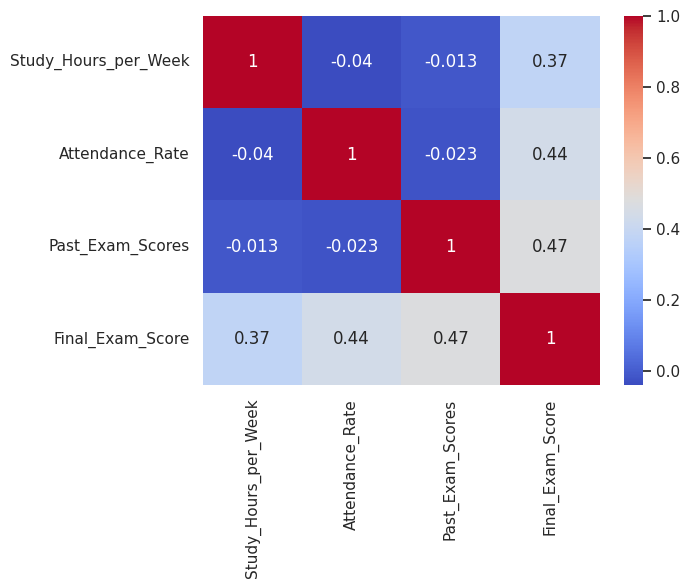

In [33]:
sns.heatmap(data[numeric_cols].corr(),annot=True, cmap='coolwarm')
plt.show()

In [70]:
# create new feature
data['Total_Study_Effort'] = data['Study_Hours_per_Week'] * data['Attendance_Rate']
data['Attendance_Level'] = data['Attendance_Rate'].apply(lambda x: 'Low' if x <= 75 else 'High')
data

,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail,Total_Study_Effort,Attendance_Level
0,Male,31,68.267841,86,High School,Yes,Yes,63,Pass,2116.303070,Low
1,Male,16,78.222927,73,PhD,No,No,50,Fail,1251.566834,High
2,Female,21,87.525096,74,PhD,Yes,No,55,Fail,1838.027021,High
3,Female,27,92.076483,99,Bachelors,No,No,65,Pass,2486.065041,High
4,Female,37,98.655517,63,Masters,No,Yes,70,Pass,3650.254146,High
...,...,...,...,...,...,...,...,...,...,...,...
701,Female,21,69.858192,90,Masters,Yes,No,50,Fail,1467.022024,Low
702,Female,22,93.349688,76,Bachelors,No,No,60,Pass,2053.693136,High
703,Male,14,84.658761,78,PhD,Yes,No,50,Fail,1185.222648,High
705,Male,25,98.384969,75,Bachelors,Yes,No,57,Fail,2459.624235,High


1. Có sự khác biệt đáng kể về điểm số giữa các nhóm học sinh không?

2. Trung bình điểm thi của học sinh có thể ước lượng ở mức nào?

3. Mô hình hồi quy tuyến tính có giúp dự đoán chính xác điểm số?

4. Có thể xây dựng hệ thống cảnh báo học sinh trượt không?

#### Sampling and Empirical Distributions

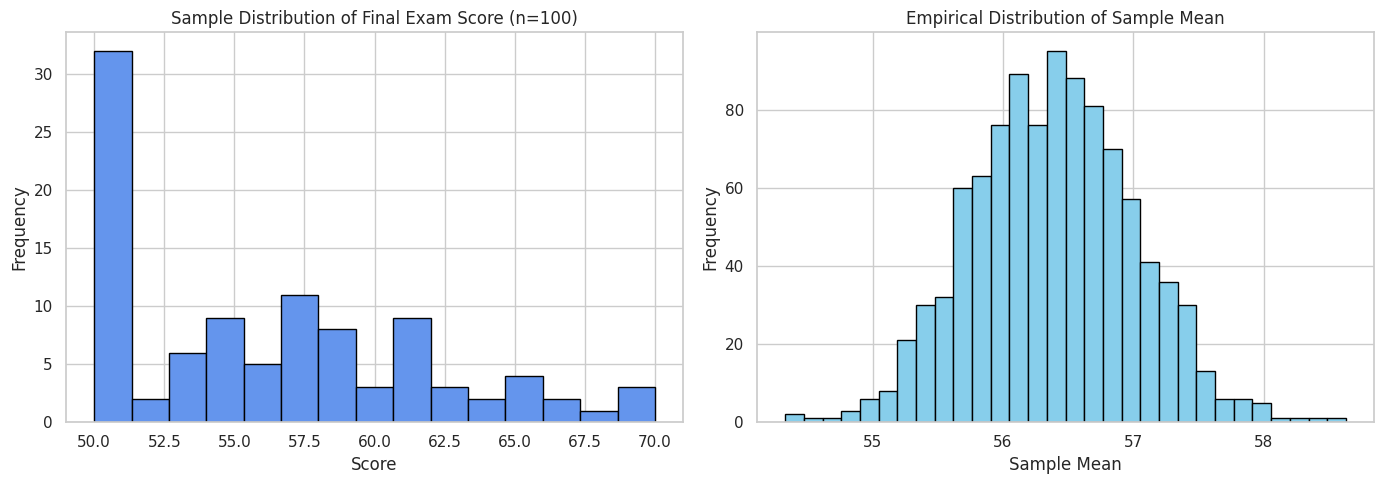

In [44]:
# 1. Lấy mẫu ngẫu nhiên
sample = data.sample(100, random_state=1)

# 2. Lặp lại sampling 1000 lần để lấy sample means
sample_means = []
for _ in range(1000):
    s = data.sample(100, replace=True)
    sample_means.append(s['Final_Exam_Score'].mean())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Phân phối điểm từ 1 sample
axes[0].hist(sample['Final_Exam_Score'], bins=15, color='cornflowerblue', edgecolor='black')
axes[0].set_title('Sample Distribution of Final Exam Score (n=100)')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Phân phối trung bình từ nhiều sample
axes[1].hist(sample_means, bins=30, color='skyblue', edgecolor='black')
axes[1].set_title('Empirical Distribution of Sample Mean')
axes[1].set_xlabel('Sample Mean')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


$\Rightarrow$ **Nhận xét từ phần Sampling & Empirical Distribution:**

- Phân phối dữ liệu thô từ 1 mẫu (n = 100) cho thấy rõ sự lệch trái, chứng tỏ nhiều học sinh đạt điểm thấp.
- Tuy nhiên, khi thực hiện bootstrap lấy 1000 sample means (n = 100 mỗi sample), phân phối trung bình mẫu trở nên gần chuẩn.
- Đây là biểu hiện rõ ràng của **Định lý giới hạn trung tâm (Central Limit Theorem)**:
  > Dù phân phối gốc không chuẩn, nhưng trung bình mẫu sẽ xấp xỉ phân phối chuẩn nếu kích thước mẫu đủ lớn.
- Việc hiểu được tính chất này sẽ giúp yên tâm sử dụng các kỹ thuật thống kê suy luận (Inference) như Bootstrap, t-test, và tạo Confidence Interval sau đó.


---

Kiểm định 1: Có sự khác biệt điểm thi giữa các nhóm Attendance_Level không? (Kiểm định điểm trung bình Final_Exam_Score giữa các nhóm chuyên cần)

**Đặt giả thuyết:**
- $H_0$ (Null Hypothesis):
Không có sự khác biệt điểm trung bình giữa 2 nhóm Attendance_Level

- $H_1$ (Alternative Hypothesis):
Có sự khác biệt điểm trung bình giữa 2 nhóm

In [75]:
# Chia nhóm
group_high = data[data['Attendance_Level'] == 'High']['Final_Exam_Score']
group_low = data[data['Attendance_Level'] == 'Low']['Final_Exam_Score']

# Kiểm định t-test
t_stat, p_val = ttest_ind(group_high, group_low, equal_var=False)  # Welch’s t-test
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

T-statistic: 9.278
P-value: 0.0000


**Kết quả kiểm định:**
- T-statistic = 9.278
- P-value = 0.0000

**Kết luận:**
Với p-value ≪ 0.05, chúng tôi bác bỏ giả thuyết $H_0$ và kết luận rằng:
> **Attendance_Level ảnh hưởng rõ rệt đến kết quả điểm thi cuối kỳ của học sinh.**  
Học sinh chuyên cần hơn (Attendance_Level = High) có xu hướng đạt điểm thi cao hơn đáng kể.


#### Estimation (Bootstrap + Confidence Interval)

Sử dụng Bootstrap để ước lượng khoảng tin cậy (Confidence Interval) cho điểm thi trung bình của từng nhóm Attendance_Level (High và Low).

In [77]:
# trung bình từ mỗi mẫu bootstrap

def bootstrap_means(group_series, n_iterations=1000):
    means = []
    for _ in range(n_iterations):
        sample = group_series.sample(frac=1, replace=True)
        means.append(sample.mean())
    return means

# Lấy dữ liệu điểm thi của từng nhóm Attendance_Level
high_scores = data[data['Attendance_Level'] == 'High']['Final_Exam_Score']
low_scores = data[data['Attendance_Level'] == 'Low']['Final_Exam_Score']

# Bootstrap 1000 lần
high_bootstrap = bootstrap_means(high_scores)
low_bootstrap = bootstrap_means(low_scores)

ci_high = np.percentile(high_bootstrap, [2.5, 97.5])
ci_low = np.percentile(low_bootstrap, [2.5, 97.5])

print("CI 95% của nhóm Attendance High:", ci_high)
print("CI 95% của nhóm Attendance Low:", ci_low)

CI 95% của nhóm Attendance High: [ 57.7767658   59.31254647]
CI 95% của nhóm Attendance Low: [ 53.25963203  54.46753247]


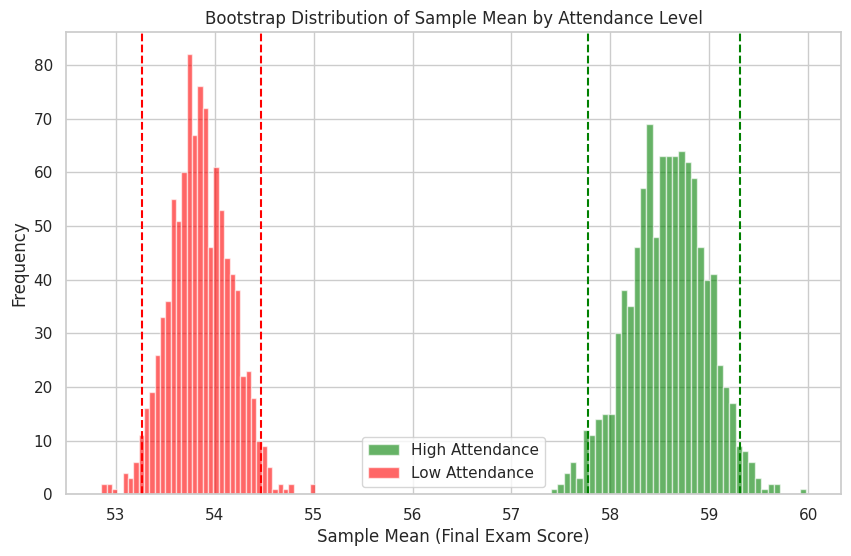

In [78]:
plt.figure(figsize=(10, 6))
plt.hist(high_bootstrap, bins=40, color='green', alpha=0.6, label='High Attendance')
plt.axvline(ci_high[0], color='green', linestyle='--')
plt.axvline(ci_high[1], color='green', linestyle='--')

plt.hist(low_bootstrap, bins=40, color='red', alpha=0.6, label='Low Attendance')
plt.axvline(ci_low[0], color='red', linestyle='--')
plt.axvline(ci_low[1], color='red', linestyle='--')

plt.title("Bootstrap Distribution of Sample Mean by Attendance Level")
plt.xlabel("Sample Mean (Final Exam Score)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Sau khi thực hiện Bootstrap 1000 lần với từng nhóm Attendance_Level ta thu được:
- Khoảng tin cậy của hai nhóm **không chồng lấn nhau**, củng cố thêm kết luận rằng **Attendance_Level có ảnh hưởng rõ rệt đến kết quả học tập**.
- Học sinh chuyên cần hơn có trung bình điểm thi cao hơn một cách ổn định, và sự khác biệt này là có ý nghĩa thống kê.
- Khoảng tin cậy hẹp chứng tỏ độ tin cậy cao trong ước lượng trung bình của từng nhóm.

## 2. Phân loại học sinh
- Phân loại học sinh trượt / không trượt
- Sử dụng các mô hình

In [120]:
data['Fail_Label'] = data['Pass_Fail'].map({'Fail': 1, 'Pass': 0})
# data['Attendance_Level'] = data['Attendance_Level'].map({'Low': 0, 'High': 1})

features = ['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Total_Study_Effort']
X = data[features]
y = data['Fail_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [121]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [122]:
y_pred = clf.predict(X_test)

print("Báo cáo phân loại:\n", classification_report(y_test, y_pred))
print("Ma trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.61      0.66      0.63        29
           1       0.86      0.83      0.84        71

    accuracy                           0.78       100
   macro avg       0.73      0.74      0.74       100
weighted avg       0.78      0.78      0.78       100

Ma trận nhầm lẫn:
 [[19 10]
 [12 59]]


In [119]:
acc = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {acc:.4f}")

Độ chính xác: 0.7800


## 3. Dự đoán điểm số
- Dự đoán điểm tương lai dựa trên dữ liệu quá khứ
- Mô hình hồi quy

In [124]:
features = ['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Total_Study_Effort']
X = data[features]
y = data['Final_Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [133]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R^2 score: {r2:.4f}")

MAE: 2.93
MSE: 13.01
R^2 score: 0.6066


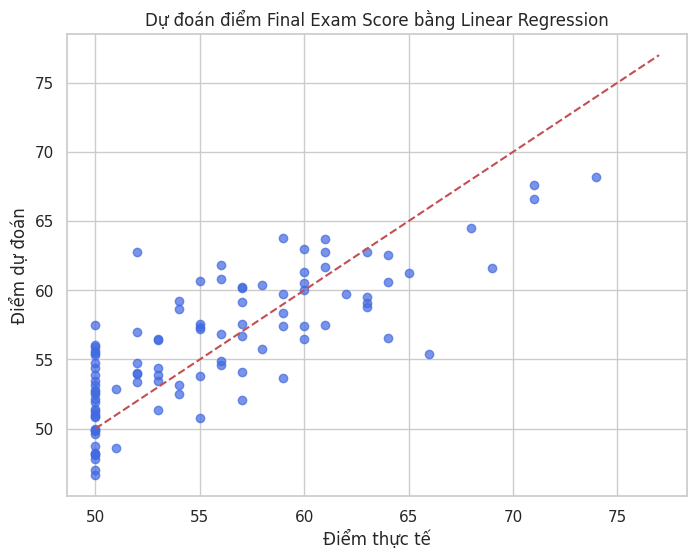

In [127]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # đường y = x
plt.xlabel("Điểm thực tế")
plt.ylabel("Điểm dự đoán")
plt.title("Dự đoán điểm Final Exam Score bằng Linear Regression")
plt.grid(True)
plt.show()

In [134]:
# Tạo mô hình hồi quy bậc 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

# Dự đoán
y_poly_pred = poly_model.predict(X_test)

# Đánh giá
poly_mae = mean_absolute_error(y_test, y_poly_pred)
poly_r2 = r2_score(y_test, y_poly_pred)

print(f"[Polynomial Regression] MAE: {poly_mae:.2f} | R^2: {poly_r2:.4f}")

[Polynomial Regression] MAE: 2.75 | R^2: 0.6122


In [131]:
X_ols = sm.add_constant(X)  # thêm hệ số chệch
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Final_Exam_Score   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     176.8
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           6.33e-94
Time:                        08:39:01   Log-Likelihood:                -1404.8
No. Observations:                 500   AIC:                             2820.
Df Residuals:                     495   BIC:                             2841.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   24.0129 

In [132]:
X_ols_test = sm.add_constant(X_test)
pred = ols_model.get_prediction(X_ols_test[:5])
pred_summary = pred.summary_frame(alpha=0.05)  # 95% interval
print(pred_summary[['mean', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower', 'obs_ci_upper']])

          mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
465  52.815520      52.125588      53.505452     44.852680     60.778359
77   59.157321      58.463740      59.850901     51.194164     67.120477
485  50.950519      50.125261      51.775777     42.974815     58.926223
170  53.624159      53.085759      54.162560     45.673016     61.575303
111  55.397381      54.597464      56.197298     47.424259     63.370503


## 4. Đánh giá mô hình

### Kết quả mô hình phân loại học sinh trượt / không trượt

Chúng tôi sử dụng mô hình **Random Forest Classifier** để phân loại học sinh có nguy cơ trượt môn Toán (`Fail = 1`) dựa trên các đặc trưng:
- Study Hours per Week
- Attendance Rate
- Past Exam Scores
- Total Study Effort

#### Hiệu quả mô hình:
- **Độ chính xác tổng thể (Accuracy):** 78%
- **F1-score cho lớp "Fail":** 0.84 → rất cao
- **Precision lớp "Fail":** 0.86 → phần lớn học sinh được dự đoán là "trượt" thực sự trượt
- **Recall lớp "Fail":** 0.83 → mô hình bắt được hầu hết các trường hợp học sinh trượt

#### Confusion matrix:
- 59 học sinh trượt được dự đoán đúng
- 12 học sinh trượt bị dự đoán nhầm là Pass
- 19 học sinh Pass được dự đoán đúng
- 10 học sinh Pass bị nhầm là trượt

#### Nhận xét:
- Mô hình có hiệu suất tốt, đặc biệt trong việc **nhận diện học sinh trượt**, vốn là mục tiêu trọng tâm của hệ thống cảnh báo sớm.
- Precision và Recall đều cân bằng ở lớp Fail → độ tin cậy của hệ thống cảnh báo cao.
- Có thể cải thiện thêm bằng cách bổ sung feature như Study_Level hoặc mô hình hóa thêm attendance theo tuần.


### Phân tích hồi quy dự đoán điểm thi

Chúng tôi triển khai 4 hướng tiếp cận khác nhau để dự đoán `Final_Exam_Score` của học sinh, gồm:

#### 1. Hồi quy tuyến tính (Linear Regression)
- MAE = 2.93, $R^2$ = 0.6066
- Giải thích tốt ~61% phương sai điểm thi
- Dễ hiểu, dễ triển khai

#### 2. Hồi quy bậc 2 (Polynomial Regression)
- MAE = 2.75, $R^2$ = 0.6122
- Cải thiện nhẹ độ chính xác → mối quan hệ phi tuyến tồn tại nhưng yếu

#### 3. Phân tích hồi quy thống kê (`statsmodels.OLS`)
- Các biến Attendance Rate, Past Exam Scores và Total Study Effort có ý nghĩa thống kê rõ (p < 0.05)
- `Study_Hours_per_Week` không có ý nghĩa (p = 0.818)
- $R^2$ = 0.588 tương đương scikit-learn

#### 4. Prediction Interval (95%)
- Mỗi học sinh được ước lượng một khoảng điểm thực tế có thể đạt được
- Phản ánh bất định trong thực tế và hữu ích trong cảnh báo rủi ro

### Kết luận:
Mô hình Linear Regression và Polynomial Regression đều đạt kết quả tốt, và inference từ OLS giúp hiểu sâu hơn về tác động của từng biến. Việc sử dụng khoảng dự đoán là bước nâng cao rất thiết thực cho hệ thống cảnh báo sớm học sinh yếu.